# CST PTM Data Overview

The PTM data from CST has a significant amount of missing data and requires special consideration when normalizing. The starting data is ratio-level-data - where log2 ratios have been calculated from the cancerous cell lines compared to the non-cancerous 'Normal Pool' data from within the 'plex'. This data is under the lung_cellline_3_1_16 directory and each PTM type has its own '_combined_ratios.tsv' file. 

This notebook will overview the ratio-level datat from the PTM types: phosphorylation, methylation, and acetylation. The figures in this notebook demonstrate that there is a systematic difference in the distributions of PTM measurements in the lung cancer cell lines regardless of PTMs with missing data are considered. The normalization procedures used to correct for this systematic bias are discussed in the [CST_PTM_Normalization_Overview](https://github.com/MaayanLab/CST_Lung_Cancer_Viz/blob/master/CST_PTM_Normalization_Overview.ipynb) notebook.

The systematic difference in average PTM ratios in the cell lines could be due to a number of factors: 
* it could be biological in nature, e.g. some cell line have uniformly higher PTM levels than others
* some cell lines might have higher/lower metabolism rates which will result in differences in incorporation of heavy isotopes
* some cell lines might reproduce faster/slower during the time period where cells are exposed to heavy isotopes, which would result in differences in the population size of the different cell lines

In any case, it can be useful towards understanding the differences in cell line behavior to remove this systematic difference. 

# Phosphorylation Data
I'll start by having a look at the phosphorylation data that can be found in 

`lung_cellline_3_1_16/lung_cellline_phospho/lung_cellline_TMT_phospho_combined_ratios.tsv`

This file was made using the `process_latest_cst_data.py` script. First I'll make the necessary imports. 

In [1]:
# imports and plotting defaults
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import matplotlib
matplotlib.style.use('ggplot')
from copy import deepcopy

# use clustergrammer module to load/process (source code in clustergrammer directory)
from clustergrammer import Network

Next, I'll load the phosphorylation ratio data and simplify the column names (to improve readability)

In [4]:
# load data data and export as pandas dataframe: inst_df
def load_data(filename):
    ''' 
    load data using clustergrammer and export as pandas dataframe
    '''
    net = deepcopy(Network())
    net.load_file(filename)
    tmp_df = net.dat_to_df()
    inst_df = tmp_df['mat']

    
    # simplify column names (remove categories)
    col_names = inst_df.columns.tolist()
#     simple_col_names = []
#     for inst_name in col_names:
#         simple_col_names.append(inst_name[0])

    inst_df.columns = col_names

    print(inst_df.shape)
    
    ini_rows = inst_df.index.tolist()
    unique_rows = list(set(ini_rows))
    
    if len(ini_rows) > len(unique_rows):
        print('found duplicate PTMs')
    else:
        print('did not find duplicate PTMs')
    
    return inst_df

filename = '../lung_cellline_3_1_16/lung_cellline_phospho/' + \
'lung_cellline_TMT_phospho_combined_ratios.tsv'
inst_df = load_data(filename)

(5798, 45)
did not find duplicate PTMs


I loaded the phosphorylation tsv file using clustergrammer and exported it as a pandas dataframe. We can see that there are 5,798 unique phosphorylation sites measured in all 45 lung cancer cell lines. 

### Missing Phosphorylation Data
However, there is also a large amount of missing data, e.g. no cell line has all 5798 phosphorylations mesaured. We can plot the number of measured phosphorylation sites (e.g. non-NaN values in the dataframe) below to get a sense of the amount of missing data

<class 'pandas.core.frame.DataFrame'>


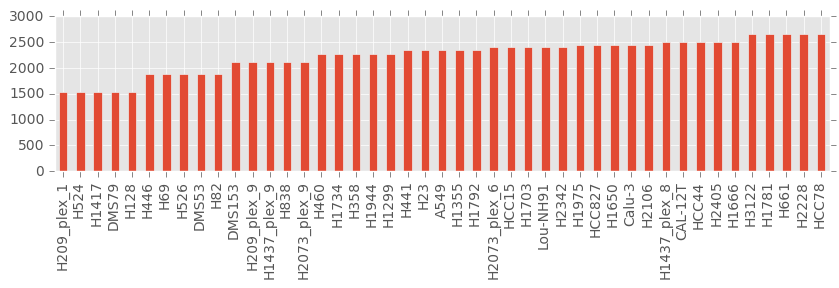

In [5]:
inst_df.count().sort_values().plot(kind='bar', figsize=(10,2))
print(type(inst_df))

In the above visualization I have ranked the cell lines based in increasing number of measurements. We can see that there is a pattern in the missing data. The 45 cell lines appear to be aranged into nine groups of 5 cell lines each. These groups correpond to the 9 'plexes', or 'batches', in which the cell lines were measured. Each plex measured one control, Normal Pool, and five cancer cell lines (note that some cell lines have been measured in more than one plex and these have their plex number appended to their name). 

### Cell Line Phosphorylation Distributions

Since each cell line has a large number of measured phosphorylations (at least 1,500) we can reasonably expect that the distributions of phosphorylation levels in the cell lines will be similar. This is based on the assumption that biological variation is not systematic and should not result in consistently higher or lower measurements in the cell lines. 

Below we plot the mean values (ratios) of all measured phosphorylations in each cell line and order the cell lines by their average phosphorylation levels in ascending order. 

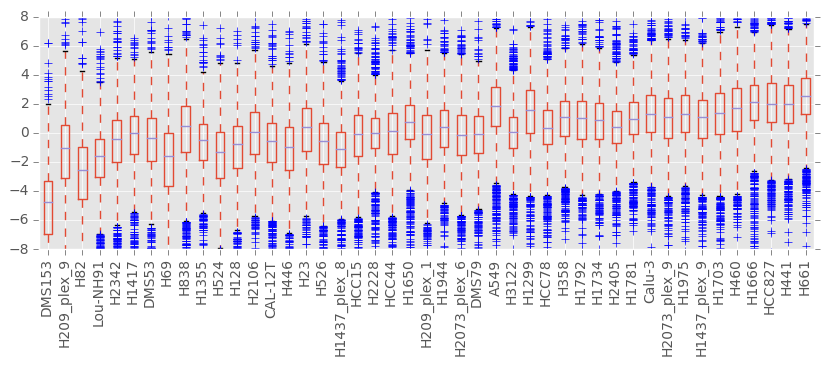

In [7]:
def plot_cl_boxplot_with_missing_data(inst_df):
    '''
    Make a box plot of the cell lines where the cell lines are ranked based 
    on their average PTM levels
    '''
    
    # get the order of the cell lines based on their mean 
    sorter = inst_df.mean().sort_values().index.tolist()
    # reorder based on ascending mean values
    sort_df = inst_df[sorter]
    # box plot of PTM values ordered based on increasing mean 
    sort_df.plot(kind='box', figsize=(10,3), rot=90, ylim=(-8,8))

plot_cl_boxplot_with_missing_data(inst_df)

We can see that there is a significant difference in the mean phosphorylation level across the cell lines. These large differenecs in the cell line distributions lead us to believe that there is a systematic error in the measurements that needs to be corrected. 

However, each cell line has a different subset of phosphorylations measured so to more fairly compare the cell lines we should only compare commonly measured phosphorylations. 

Below we plot the mean values of phosphorylations that were measured in all cell lines. 

There are 513 PTMs measured in all cell lines


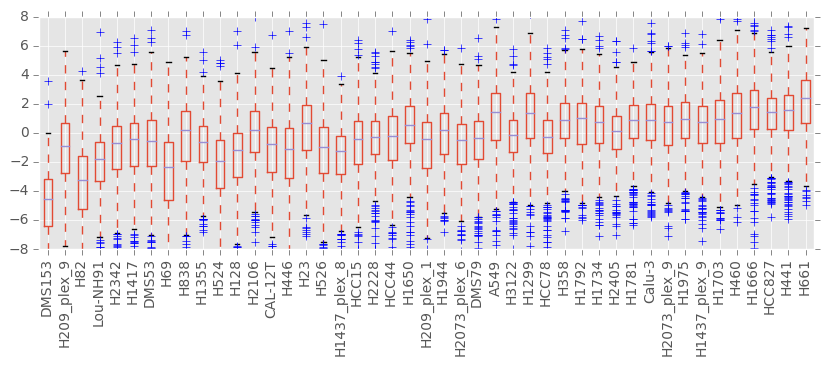

In [8]:
def plot_cl_boxplot_no_missing_data(inst_df):
    # get the order of the cell lines based on their mean 
    sorter = inst_df.mean().sort_values().index.tolist()
    # reorder based on ascending mean values
    sort_df = inst_df[sorter]

    # transpose to get PTMs as columns 
    tmp_df = sort_df.transpose()

    # keep only PTMs that are measured in all cell lines
    ptm_num_meas = tmp_df.count()
    ptm_all_meas = ptm_num_meas[ptm_num_meas == 45]
    ptm_all_meas = ptm_all_meas.index.tolist()

    print('There are ' + str(len(ptm_all_meas)) + ' PTMs measured in all cell lines')
    
    # only keep ptms that are measured in all cell lines 
    # I will call this full_df as in no missing measurements
    full_df = tmp_df[ptm_all_meas]

    # transpose back to PTMs as rows
    full_df = full_df.transpose()

    full_df.plot(kind='box', figsize=(10,3), rot=90, ylim=(-8,8))
    num_ptm_all_meas = len(ptm_all_meas)

plot_cl_boxplot_no_missing_data(inst_df)

From the above box plot we can see that there is a significant difference in the distributions of the cell lines even when we only consider phosphorylations that were measured in all cell lines (note that the cell lines are in the same order as the previous box plot). This indicates that this systematic differnce in average phosphorylation values is not caused by missing values. 

Since we do not expect biological variation to cause this type of systematic difference between cell lines we can conclude that the large differences between cell lines are likely the result of systematic experimental error that should be corrected. Normalizing the data will be discussed [here](https://github.com/MaayanLab/CST_Lung_Cancer_Viz)

# Acetylation Data
I will perform the same overview on the acetylation data. There are 1,192 unique acetylations measured in the 45 cell lines. 

In [9]:
filename = '../lung_cellline_3_1_16/lung_cellline_Ack/' + \
    'lung_cellline_TMT_Ack_combined_ratios.tsv'
inst_df = load_data(filename)

(1192, 45)
did not find duplicate PTMs


### Missing Acetylation Data

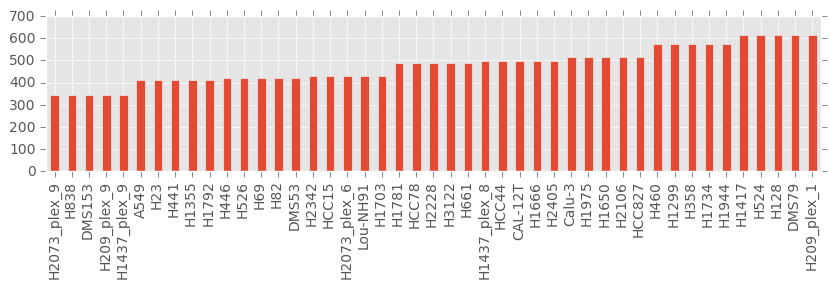

In [10]:
inst_df.count().sort_values().plot(kind='bar', figsize=(10,2))

### Cell Line Acetylation Distributions

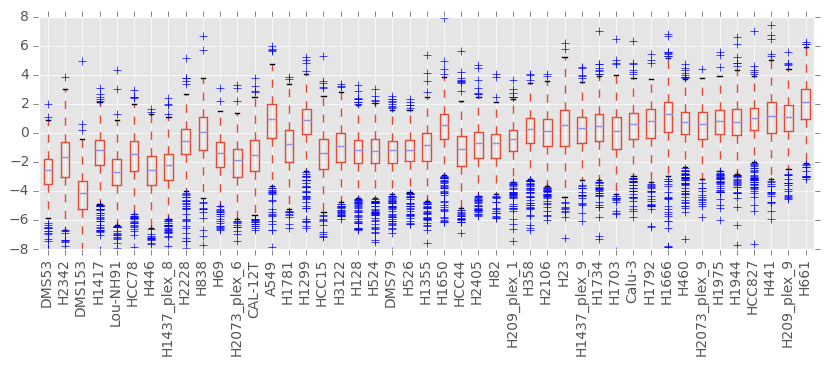

In [11]:
plot_cl_boxplot_with_missing_data(inst_df)

Distribution of Acetylation data that was measured in all cell lines

There are 125 PTMs measured in all cell lines


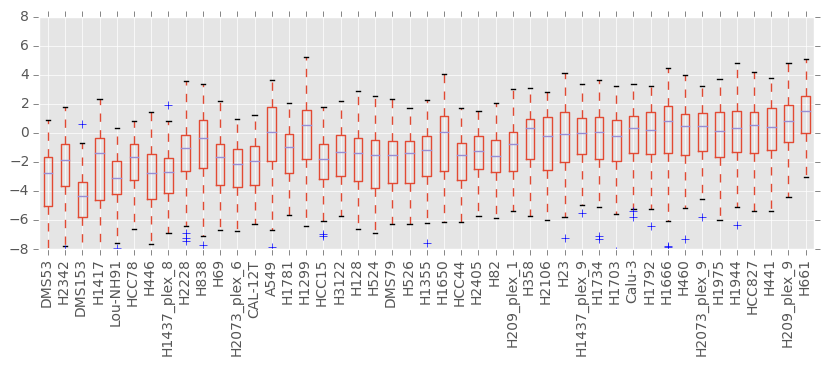

In [12]:
plot_cl_boxplot_no_missing_data(inst_df)

# Methylation Data
The methylation data has been broken up into Arginine and Lysine methylation.

## Arginine Methylation 
There are 1,248 Arginine methylations measured in all 42 cell lines

In [13]:
filename = '../lung_cellline_3_1_16/lung_cellline_Rme1/' + \
'lung_cellline_TMT_Rme1_combined_ratios.tsv'
inst_df = load_data(filename)

(1248, 45)
did not find duplicate PTMs


### Missing Arginine Methylation Data

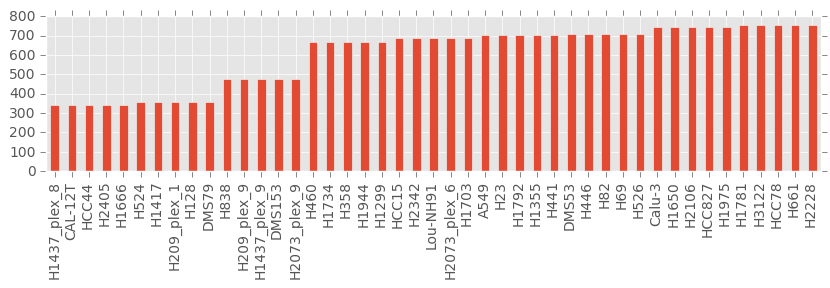

In [14]:
inst_df.count().sort_values().plot(kind='bar', figsize=(10,2))

### Cell Line Arginine Methylation Distributions

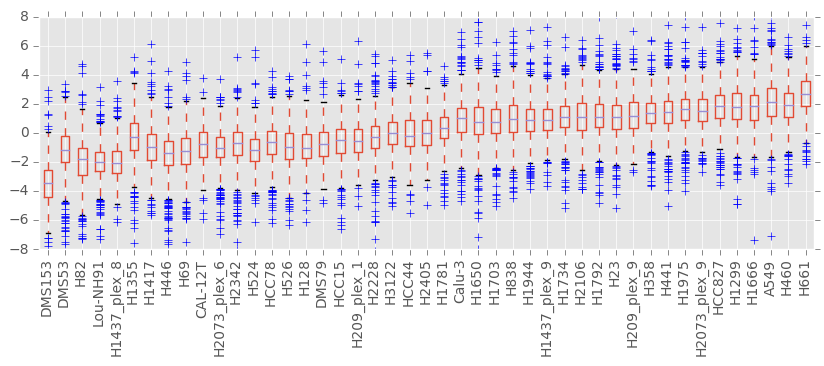

In [15]:
plot_cl_boxplot_with_missing_data(inst_df)

Argining Methylation that was measured in all cell lines 

There are 193 PTMs measured in all cell lines


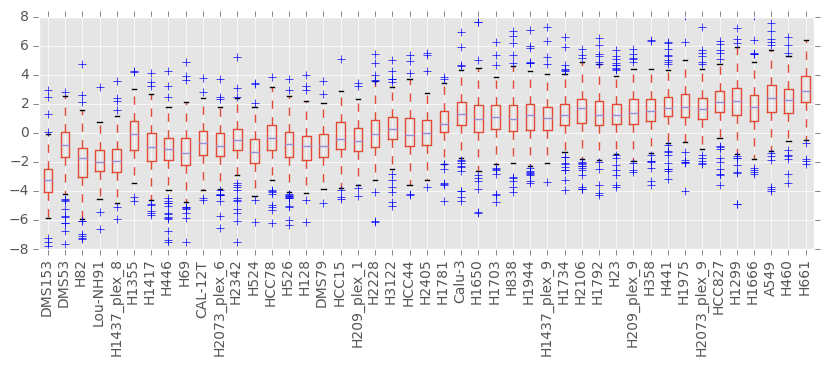

In [16]:
plot_cl_boxplot_no_missing_data(inst_df)

## Lysine Methylation Data
There are 230 lysine methylations measured in all cell line

In [17]:
filename = '../lung_cellline_3_1_16/lung_cellline_Kme1/' + \
'lung_cellline_TMT_Kme1_combined_ratios.tsv'
inst_df = load_data(filename)

(230, 45)
did not find duplicate PTMs


### Missing Lysine Methylation Data
Some cell lines have as few as 40 lysine methylations measured.

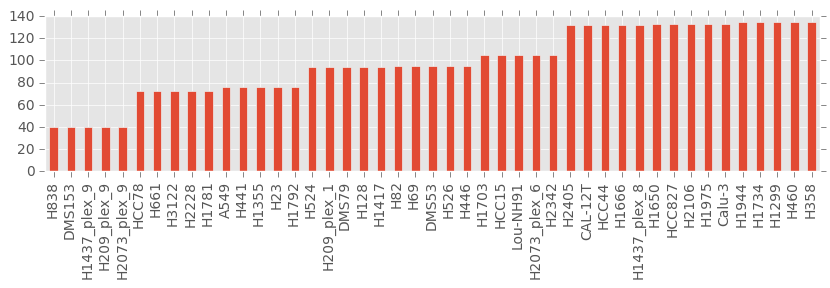

In [18]:
inst_df.count().sort_values().plot(kind='bar', figsize=(10,2))

### Cell Line Lysine Metylation Distributions

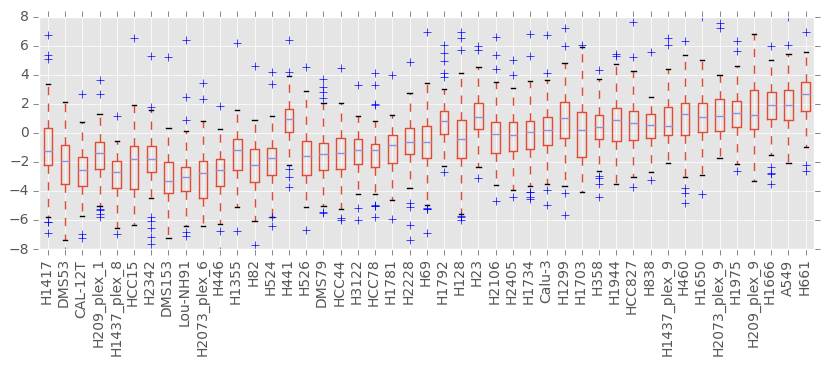

In [19]:
plot_cl_boxplot_with_missing_data(inst_df)

Lysine methylation that was measured in all cell lines 

There are 26 PTMs measured in all cell lines


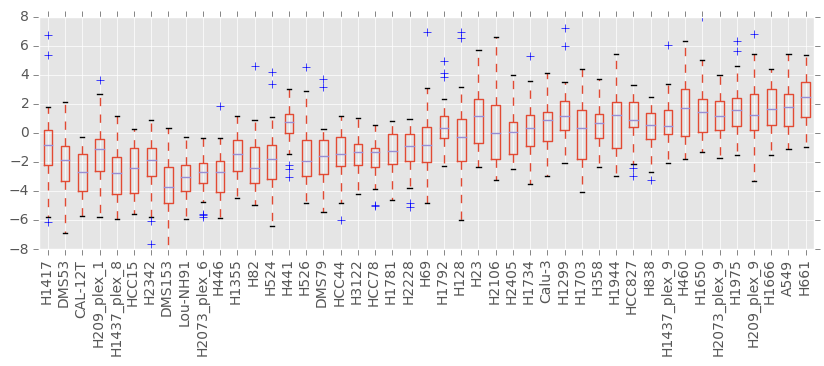

In [20]:
plot_cl_boxplot_no_missing_data(inst_df)

There were only 26 lysine methylations that were measured in all cell lines. We still see the bias in the average values across the cell lines. 

# Conclusions
We see that the PTM measurements (phosphorylation, acetylation, and methylation) all show large differences in average behavior across the cell lines. Furthermore, the cell lines with the highest and lowest ratios are frequently the same: DMS153 is hte cell line with the lowest ratios and H661 is the cell line with the highest ratios in all cases. '

In other words, if we were to ask which cell line has the highest or lowest level of a particular PTM site we would almost always get the same cell line no matter which site we were interested in. Since this type of uniform and systematic difference between cell lines is not what we expect biologically we can conclude that the ratio data should be normalized in some way. The normalization procedure and its affects on cell line clustering are discussed in the notebook [CST_PTM_Normalization_Overview](https://github.com/MaayanLab/CST_Lung_Cancer_Viz/blob/master/CST_PTM_Normalization_Overview.ipynb) notebook.